In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot


import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

## Make data

In [2]:
n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate SBMs from parameters
undirected_sbm = sbm(2 * [n_verts], P)
directed_sbm = sbm(2 * [n_verts], P, directed=True)

## Using graspologic ZG(2) method

In [3]:
from graspologic.embed import select_dimension
select_dimension(undirected_sbm)

([2, 4], [60.040654885507344, 11.571250884605346])

## Example use of using sklean minka estimation

In [4]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

def minka(X):
    n_components = 'mle'
    n_samples = X.shape[0]
    U, S, Vt = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    singular_values_ = S.copy()  # Store the singular values.

    # Postprocess the number of components required
    if n_components == 'mle':
        n_components = \
            _infer_dimension(explained_variance_, n_samples)
    return n_components

In [5]:
minka(undirected_sbm)

3

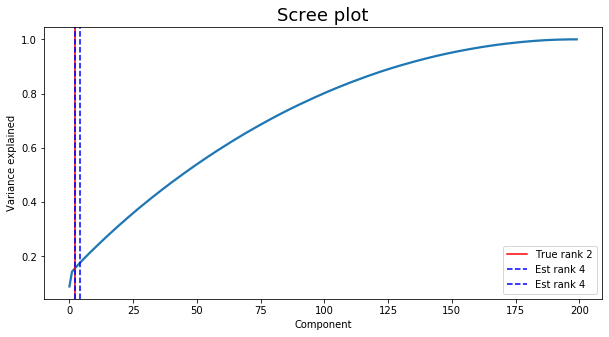

In [7]:
from graspologic.plot import screeplot
screeplot(undirected_sbm)
plt.axvline(2, label='True rank {}'.format(2), color='red')
plt.axvline(4, label='Est rank {}'.format(4), color='blue', ls='--')
plt.axvline(2, label='Est rank {}'.format(4), color='blue', ls='--')
plt.legend()

In [9]:
import scipy
k = int(np.ceil(np.log2(np.min(undirected_sbm.shape))))
D = scipy.sparse.linalg.svds(A=undirected_sbm, k=k, return_singular_vectors=False)
D = np.sort(D)[::-1]

In [10]:
D

array([98.90493025, 60.04065489, 12.11399685, 11.57125088, 11.23993611,
       10.94278271, 10.67831547, 10.43480617])

# Simulation 1

So I would like some input about my experiment design!

I make a corrupted basis and then add on linear combinations of that basis to the end of matrix. I had anticpated that this would allow me to say that there would be 20 principal components and then in make linear combos I create 15 dependent columns. 

I sammple from normal distribution to get a matrix, of 20, 20. Then I perform svd to get U the orthongonal basis which would would have the number of columsn of principal components (because they are all independent). 

then to create the llinear combinations I choose random columns(using randint, discrete uniform) and random.rand created the coefficients to multiply each column by (random samples from a uniform distribution over  0-1). 

In order to perturb the matrix, a matrix of random numbers (noraml distribution decided upon at each experiment for mu and std) and then to an element wise addition of these two matrices. 

In [11]:
import random 
def make_linear_combos(U):
    vecs = np.zeros((U.shape[0], 15))
    lin_comb = 5
    for i in range(vecs.shape[1]):
        coefs = np.random.rand(lin_comb,1)
        inds = np.random.randint(0,U.shape[1], lin_comb)
        for j in range(lin_comb):
            vecs[:, i] += U[:, inds[j]] * coefs[j]
    return vecs
    

In [12]:
def make_corrupted_basis(size =20):    
    X_sim = np.random.normal(0, 1, (size, size))
    U, S, Vt = linalg.svd(X_sim)
    # this has rank 10 so we would expect that d chose to be 10 with superfluous parts on matrix
    uncorrupted_basis = U[:, :int(size/2)]
    v = make_linear_combos(U)
    corrupted_basis = np.hstack((uncorrupted_basis, v ))
    return corrupted_basis

In [13]:
# pertub matrix meaning that we have X + Delta where delta is random noise
# noise in this case will be normal 
def perturb(X, mu, std):
    perturb = np.random.normal(mu, std, (X.shape[0], X.shape[1]))
    return X + perturb

In [14]:
corrupted_basis = make_corrupted_basis()

In [15]:
select_dimension(corrupted_basis)[0]

[1, 3]

In [16]:
minka(corrupted_basis)

1

The experiment is as follows we start at 0 perturbation where both minka and ZG(2) should give us the same answer. Then we shall continue to perturb the matrix with larger and larger mu, std, and mu and std(maybe?). We shall graphically see which one changes with more perturbations

In [64]:
simulation_size = 50

### std

In [65]:
stds = np.arange(0, 1.1, .1)
std_rem = []
mus = np.arange(0, 11, 1)
corrupted_basis = make_corrupted_basis()
m_est = []
zg_est = []
for i in range(stds.shape[0]):
    zg_helper = []
    minka_helper = []
    for j in range(simulation_size):
        perturbed = perturb(corrupted_basis, 0, stds[i])
        zg_helper.append(select_dimension(perturbed)[0])
        minka_helper.append(minka(perturbed))
    if np.asarray(zg_helper).shape != (simulation_size, 2):
        std_rem.append(stds[i])
        continue        
    m_est.append(np.mean(np.asarray(minka_helper)))    
    zg_est.append([np.mean(np.asarray(zg_helper)[:, 0]), np.mean(np.asarray(zg_helper)[:, 1]) ])
zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

In [66]:
m_est.shape

(7,)

In [67]:
zg_est.shape

(7, 2)

In [68]:
stds = list(stds)
for i in range(len(std_rem)):
    stds.remove(std_rem[i])

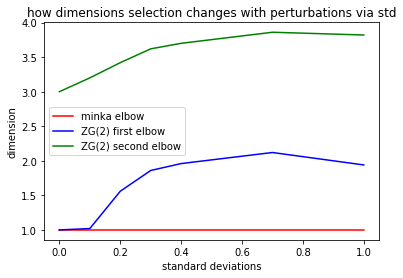

In [69]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(stds, m_est,c = 'red', label = 'minka elbow')
ax.plot(stds, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(stds, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via std")
ax.set(xlabel = "standard deviations", ylabel="dimension")
plt.show()


### mu

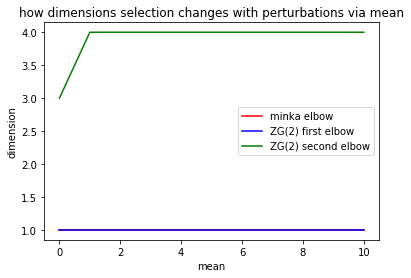

In [70]:
import matplotlib.pyplot as plt

stds = np.arange(0, 1.1, .1)
std_rem = []
mus = np.arange(0, 11, 1)
mus_rem = []
corrupted_basis = make_corrupted_basis()
m_est = []
zg_est = []
for i in range(mus.shape[0]):
    zg_helper = []
    minka_helper = []
    for j in range(simulation_size):
        perturbed = perturb(corrupted_basis, mus[i], 0)
        zg_helper.append(select_dimension(perturbed)[0])
        minka_helper.append(minka(perturbed))
    if np.asarray(zg_helper).shape != (simulation_size, 2):
        mus_rem.append(mus[i])
        continue        
    m_est.append(np.mean(np.asarray(minka_helper)))    
    zg_est.append([np.mean(np.asarray(zg_helper)[:, 0]), np.mean(np.asarray(zg_helper)[:, 1]) ])
zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

mus = list(mus)
for i in range(len(mus_rem)):
    mus.remove(mus_rem[i])
    

fig, ax = plt.subplots()
ax.plot(mus, m_est,c = 'red', label = 'minka elbow')
ax.plot(mus, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(mus, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via mean")
ax.set(xlabel = "mean", ylabel="dimension")
plt.show()

### mu and std = 1

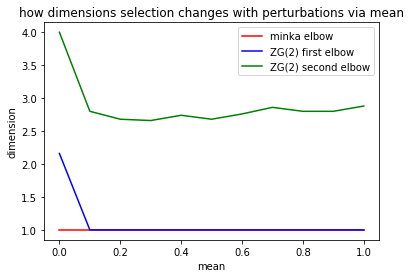

In [71]:
import matplotlib.pyplot as plt

stds = np.arange(0, 1.1, .1)
std_rem = []
mus = np.arange(0, 11, 1)
mus_rem = []
corrupted_basis = make_corrupted_basis()
m_est = []
zg_est = []
for i in range(mus.shape[0]):
    zg_helper = []
    minka_helper = []
    for j in range(simulation_size):
        perturbed = perturb(corrupted_basis, mus[i], 1)
        zg_helper.append(select_dimension(perturbed)[0])
        minka_helper.append(minka(perturbed))
    if np.asarray(zg_helper).shape != (simulation_size, 2):
        mus_rem.append(mus[i])
        continue        
    m_est.append(np.mean(np.asarray(minka_helper)))    
    zg_est.append([np.mean(np.asarray(zg_helper)[:, 0]), np.mean(np.asarray(zg_helper)[:, 1]) ])
zg_est = np.asarray(zg_est)
m_est = np.asarray(m_est)

mus = list(mus)
for i in range(len(mus_rem)):
    mus.remove(mus_rem[i])

fig, ax = plt.subplots()
ax.plot(stds, m_est,c = 'red', label = 'minka elbow')
ax.plot(stds, zg_est[:, 0],c = 'blue', label = 'ZG(2) first elbow')
ax.plot(stds, zg_est[:, 1],c = 'green', label = 'ZG(2) second elbow')
ax.legend()
plt.title("how dimensions selection changes with perturbations via mean")
ax.set(xlabel = "mean", ylabel="dimension")
plt.show()

What we have just shown above is the stability of ZG compared to minka. Minka appears to always get the Rank (1) correct. and does not suffer much from variation. ZG seems to be a little more sensitive to standard deviation perturbations more than mean. 

# Simulation 2

